<a href="https://colab.research.google.com/github/AsherReedy/Monte-Carlo-iRisk-Lab-Meetings-and-Homework/blob/main/IRisk_Meeting05_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IRisk — Meeting 5

GBM Stock Path

Binomial Approximation

Payoff Tables

Replicating Portfolio

Time‑Step Convergence

Exotic Option MC

**How to use:** Run cells top‑to‑bottom. Each section starts with a single‑sentence summary of what the code shows.

## 0) Parameters (edit as needed)

In [44]:
import numpy as np, math, matplotlib.pyplot as plt
from dataclasses import dataclass

plt.rcParams['figure.figsize']=(6,4)
plt.rcParams['axes.grid']=True

# --- Core parameters (1-year horizon) ---
S0    = 100.0    # initial stock price
K     = 100.0    # strike for options
r     = 0.00     # risk-free (cont. comp., annual)
sigma = 0.10     # annualized volatility
T     = 1.0      # years
SEED  = 2025
rng   = np.random.default_rng(SEED)

print(f"S0={S0}, K={K}, r={r}, sigma={sigma}, T={T}, seed={SEED}")

S0=100.0, K=100.0, r=0.0, sigma=0.1, T=1.0, seed=2025


## 1) Demonstrate a single GBM stock path

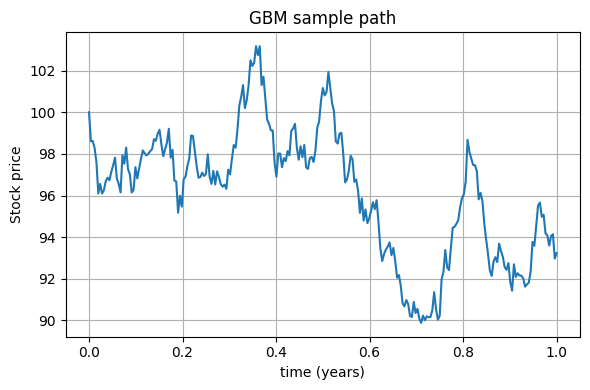

In [45]:
# Sentence: Simulate one GBM path to visualize a realistic continuous-time stock trajectory over [0,T].
def gbm_path(S0, r, sigma, T, n_steps, rng):
    dt = T/n_steps
    S = np.empty(n_steps+1); S[0]=S0
    for t in range(1, n_steps+1):
        Z = rng.standard_normal()
        S[t] = S[t-1]*np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
        #Solution to the SDE with closed time step and using the random walk from Z

    return S

n_steps = 252  # daily-ish
S = gbm_path(S0, r, sigma, T, n_steps, rng)
t = np.linspace(0, T, n_steps+1)

plt.figure()
plt.plot(t, S)
plt.xlabel("time (years)"); plt.ylabel("Stock price")
plt.title("GBM sample path")
plt.tight_layout(); plt.show()

## 2) Binomial approximation: show paths with increasing number of time steps

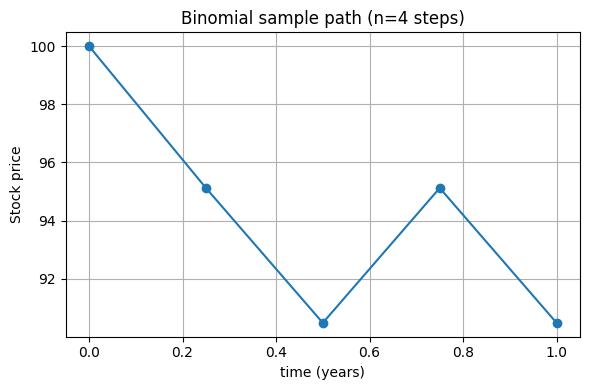

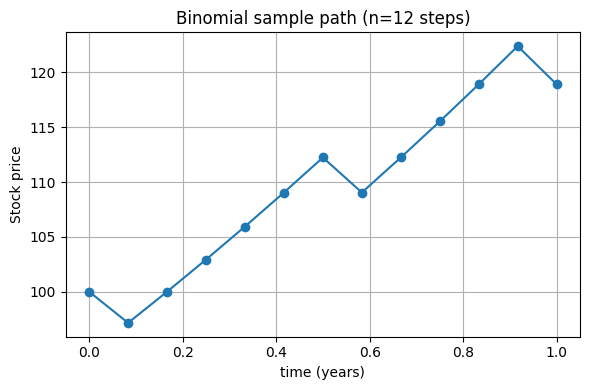

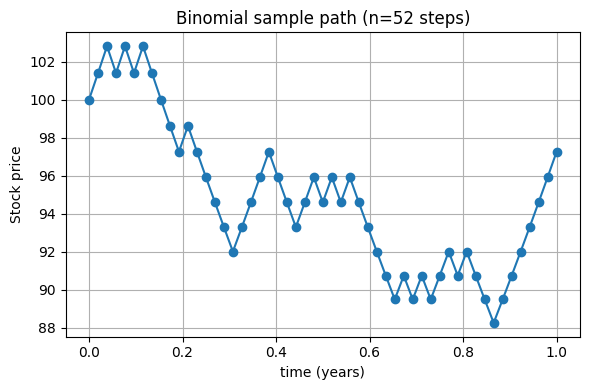

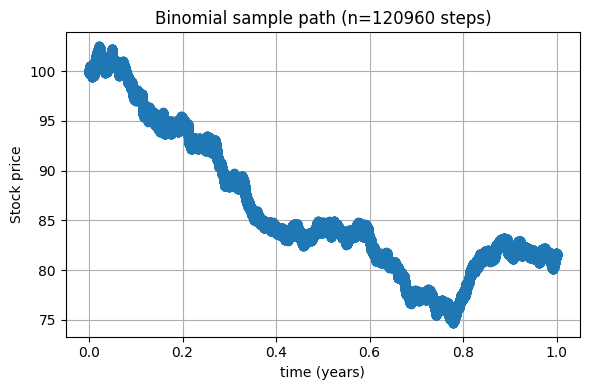

In [46]:
# Sentence: Show how binomial paths (recombining up/down steps) visually approach GBM as n increases.
def crr_params(sigma, r, T, n):
    dt = T/n
    u = math.exp(sigma*math.sqrt(dt))
    d = 1.0/u
    p = (math.exp(r*dt)-d)/(u-d)  # risk-neutral prob (requires 0<p<1)
    return u, d, p, dt

def binomial_sample_path(S0, r, sigma, T, n, rng):
    u, d, p, dt = crr_params(sigma, r, T, n)
    # draw n up/down moves, then map to prices
    ups = rng.binomial(1, p, size=n)  # 1=up, 0=down
    steps = np.where(ups==1, u, d)
    S = S0*np.cumprod(np.concatenate(([1.0], steps)))
    t = np.linspace(0, T, n+1)
    return t, S

for n in [4, 12, 52, 252*8*60]:
    t_b, S_b = binomial_sample_path(S0, r, sigma, T, n, rng)
    #print(S_b)
    plt.figure()
    plt.plot(t_b, S_b, marker='o', linestyle='-')
    plt.xlabel("time (years)"); plt.ylabel("Stock price")
    plt.title(f"Binomial sample path (n={n} steps)")
    plt.tight_layout(); plt.show()

## 3) Payoff table for call and put at maturity for different ending stock prices

In [47]:
# Build a small table of terminal payoffs for both a call and a put across a range of S_T values.
import numpy as np
import pandas as pd

# Inputs (edit K if needed)
K = 100.0
S_grid = np.array([60, 80, 90, 100, 110, 120, 140], dtype=float)

call_pay = np.maximum(S_grid - K, 0.0)
put_pay  = np.maximum(K - S_grid, 0.0)

df_pay = pd.DataFrame({
    "S_T": S_grid,
    "Call payoff = max(S_T - K, 0)": call_pay,
    "Put payoff  = max(K - S_T, 0)": put_pay
})

df_pay


,S_T,"Call payoff = max(S_T - K, 0)","Put payoff = max(K - S_T, 0)"
0,60.0,0.0,40.0
1,80.0,0.0,20.0
2,90.0,0.0,10.0
3,100.0,0.0,0.0
4,110.0,10.0,0.0
5,120.0,20.0,0.0
6,140.0,40.0,0.0


## 4) One‑period call pricing via a replicating portfolio

In [48]:
# Price a one-step European call by solving for (Delta shares, B cash) that replicate the up/down payoffs.
def one_step_replicating_price(S0, K, r, sigma, T):
    n=1
    u,d,p,dt = crr_params(sigma, r, T, n)
    Su, Sd = S0*u, S0*d
    Cu, Cd = max(Su-K,0.0), max(Sd-K,0.0)
    Delta  = (Cu - Cd)/(Su - Sd)
    B      = math.exp(-r*dt)*(Cu - Delta*Su)
    V0     = Delta*S0 + B
    return {"u":u,"d":d,"p*":p,"dt":dt,"Su":Su,"Sd":Sd,"Cu":Cu,"Cd":Cd,"Delta":Delta,"B":B,"Price":V0}

ex = one_step_replicating_price(S0, K, r, sigma, T)
for k,v in ex.items():
    print(f"{k:>5}: {v:.6f}")

    u: 1.105171
    d: 0.904837
   p*: 0.475021
   dt: 1.000000
   Su: 110.517092
   Sd: 90.483742
   Cu: 10.517092
   Cd: 0.000000
Delta: 0.524979
    B: -47.502081
Price: 4.995837


## 5) Convergence: option price as the number of binomial steps increases

n=  1  Call=4.995837
n=  2  Call=3.534062
n=  5  Call=4.190532
n= 10  Call=3.889463
n= 25  Call=4.027761
n= 50  Call=3.967873
n=100  Call=3.977804


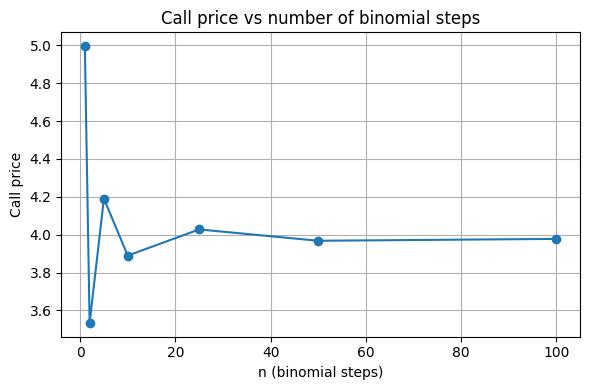

In [49]:
# Show call price (tree) approaching a stable value as n increases.
def binomial_price_call(S0, K, r, sigma, T, n):
    u,d,p,dt = crr_params(sigma, r, T, n)
    disc = math.exp(-r*dt)
    # terminal prices and payoffs
    ST = np.array([S0*(u**j)*(d**(n-j)) for j in range(n+1)])
    V  = np.maximum(ST - K, 0.0)
    # backward induction
    for _ in range(n):
        V = disc*(p*V[1:] + (1-p)*V[:-1])
    return float(V[0])

ns = [1,2,5,10,25,50,100]
prices = []
for n in ns:
    prices.append(binomial_price_call(S0,K,r,sigma,T,n))
    print(f"n={n:>3}  Call={prices[-1]:.6f}")

plt.figure()
plt.plot(ns, prices, marker='o')
plt.xlabel("n (binomial steps)"); plt.ylabel("Call price")
plt.title("Call price vs number of binomial steps")
plt.tight_layout(); plt.show()

According to the Black-Scholes model, the price is 3.99 with infinite time steps

## 6) Exotic option MC: payoff = max(S_max − K, 0) (fixed‑strike lookback call)

We have analytical tools to find the price of basic options.

Monte Carlo is helpful when we have special types of options, called exotics.

In this example, the payout is based on the maximum stock price that occurs in a year.

Exotic lookback call (max(S_max-K,0)) MC price ≈ 7.853237  with Npaths=100000, steps=252


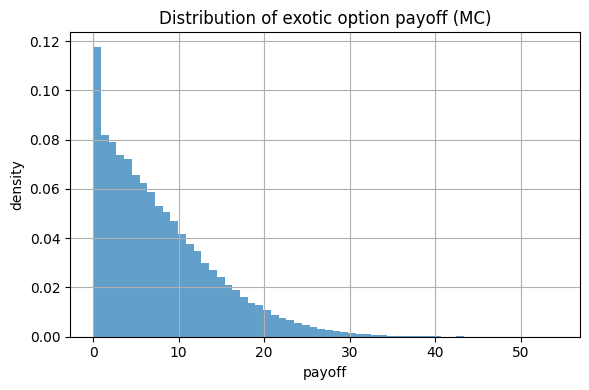

In [50]:
# Simulate GBM paths, compute S_max along each path, and estimate the discounted expected payoff.
def gbm_paths(S0, r, sigma, T, n_steps, Npaths, rng):
    dt = T/n_steps
    S = np.full((Npaths,), S0)
    Smax = S.copy()
    for _ in range(n_steps):
        Z = rng.standard_normal(Npaths)
        S *= np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
        Smax = np.maximum(Smax, S)
    return S, Smax

Npaths = 100_000
n_steps = 252
ST, Smax = gbm_paths(S0, r, sigma, T, n_steps, Npaths, rng)
payoff = np.maximum(Smax - K, 0.0)
price  = float(np.mean(np.exp(-r*T)*payoff))

print(f"Exotic lookback call (max(S_max-K,0)) MC price ≈ {price:.6f}  with Npaths={Npaths}, steps={n_steps}")
plt.figure()
plt.hist(payoff, bins=60, density=True, alpha=0.7)
plt.xlabel("payoff"); plt.ylabel("density")
plt.title("Distribution of exotic option payoff (MC)")
plt.tight_layout(); plt.show()

# Homework 5
Due 10/10 by 11:59PM

Some resources used:
- https://www.youtube.com/watch?v=pkuQLFI13Ws
- https://www.youtube.com/watch?v=35n7TICJbLc
- https://www.youtube.com/watch?v=K2Iy8bCmXjk
- https://bookdown.org/yg484/lec_3_note/no-arbitrage-principle.html

**Q1.** An American option allows you to exercise the option at any time step before the end. How is this different than the exotic option above? Research a way to price an American option in the binomial model and price an American option with $S_0=100.0, K=100.0, r=0.0, \sigma=0.1, T=1.0, n=252$.

**Explanation:**
<font color="#39e75f">  
The exotic option is called a lookback option, the payoff is determined by the maximum (or minimum) price the stock reaches within the timeframe. This gives the option holder hindsight over the performance of the stock and allows them to benefit from the best possible price the stock achieved.
<font color="#39e75f">  
American options don't grant this hindsight, instead they provide the option holder control over **when** they excersise the option, offering flexibility.
<font color="#39e75f">  
In contrast to lookback options, holders of American options must time the market and may lose out on profit if they excersise the option too early. As a result American options are cheaper than lookback options.



In [51]:
# code for Q1, American Option

# It isn't optimal to excersise an american call option early if there are no dividends and the interest rate is positve
# This is because we'd have to pay K earlier and would miss out on interest, if S(t) increased, it would be better to sell the option on the market instead of excersising it because we would keep the time value component of the option price
# It is optimal to excersise a put early because we'd get K - S(t) that could be immediately invested at the risk free rate r.

S0 = 100.0
K = 100.0
r = 0.03      # risk free rate
sigma = 0.1
T = 1.0
n = 252
SEED = 2025
rng = np.random.default_rng(SEED)

def american_option(S0, K, r, sigma, T, n, option_type="put"):
    u, d, p, dt = crr_params(sigma, r, T, n)
    disc = math.exp(-r * dt)  # discount factor per step

    # Initialize stock prices at maturity , Underlying
    S = np.zeros(n+1)
    for j in range(n+1):
        S[j] = S0 * (u**(n-j)) * (d**(j))

    # Initialize option values at maturity
    V = np.zeros(n+1)
    for j in range(n+1):
        if option_type == "call":
            V[j] = np.maximum(S[j] - K, 0)
        elif option_type == "put":
            V[j] = np.maximum(K - S[j], 0)

    # Backward induction
    for i in np.arange(n-1, -1, -1):
        for j in range(i+1):
            S_ij = S0 * (u**(i-j)) * (d**(j)) # Stock price at node (i, j)
            continuation_value = disc * (p * V[j] + (1-p) * V[j+1])
            if option_type == "call":
                exercise_value = np.maximum(S_ij - K, 0)
            elif option_type == "put":
                exercise_value = np.maximum(K - S_ij, 0)
            V[j] = np.maximum(continuation_value, exercise_value)

    return V[0]

call_price = american_option(S0, K, r, sigma, T, n, option_type="call")
put_price = american_option(S0, K, r, sigma, T, n, option_type="put")

print(f"American Call Price: {call_price:.6f}")
print(f"American Put Price: {put_price:.6f}")

American Call Price: 5.577818
American Put Price: 2.924408


**Q2.** Choose one of these exotic options: Asian, Barrier, Binary. Write code that uses a Monte Carlo simulation to price such your option. You will share your results for the next homework.

**Explanation:**

**Binary Option Model**
<font color="#39e75f">  
Binary options are an "all or nothing" contract based on a prediction about an assets price rising or falling beyond a future price at the time of experation. A correct prediction results in a fixed payout while an incorrect prediction results in a complete loss of the investment.
<font color="#39e75f">  
These options are priced by discounting the average payoff back to the present using the risk free rate.
<font color="#39e75f">  
Binary options are widely considered gambling and are banned in many countries due to the "all or nothing" payoff, short duration, and house edge.



In [52]:
#code for Q2
import numpy as np
import matplotlib.pyplot as plt

S0 = 100.0
r = 0.0    # risk free rate
K = 100
sigma = 0.1
T = 1.0
SEED = 2025
rng = np.random.default_rng(SEED)

def gbm_terminal(S0, r, sigma, T, n_paths, rng):
    # Simulate stock prices under GBM.
    Z = rng.standard_normal(n_paths)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    return ST

def binary_option_montecarlo(S0, K, r, sigma, T, n_paths=100_000, seed=SEED, payout=1.0, option_type="call"):
    rng = np.random.default_rng(seed)
    ST = gbm_terminal(S0, r, sigma, T, n_paths, rng)


    if option_type == "call":
        payoffs = np.where(ST > K, payout, 0.0)  # if underlying is greater than strike, get payout
        s = sum(ST > K)
        p_payoff = s/n_paths
    elif option_type == "put":
        payoffs = np.where(ST < K, payout, 0.0)
        s = sum(ST < K)
        p_payoff = s/n_paths

    price = np.exp(-r * T) * np.mean(payoffs)  # price is the discounted value of the expected payoff
    stderr = np.exp(-r * T) * np.std(payoffs) / np.sqrt(n_paths)
    return price, stderr, p_payoff

price_call, se_call, p_payoff_call = binary_option_montecarlo(S0, K, r, sigma, T, option_type="call")
price_put, se_put, p_payoff_put = binary_option_montecarlo(S0, K, r, sigma, T, option_type="put")

print(f"Binary Call Price: {price_call:.5f} ± {se_call:.5f}, P(payoff): {p_payoff_call}")
print(f"Binary Put Price:  {price_put:.5f} ± {se_put:.5f}, P(payoff): {p_payoff_put}")

# probability of payout is equal to price when r = 0 and payout = 1


Binary Call Price: 0.47780 ± 0.00158, P(payoff): 0.4778
Binary Put Price:  0.52220 ± 0.00158, P(payoff): 0.5222


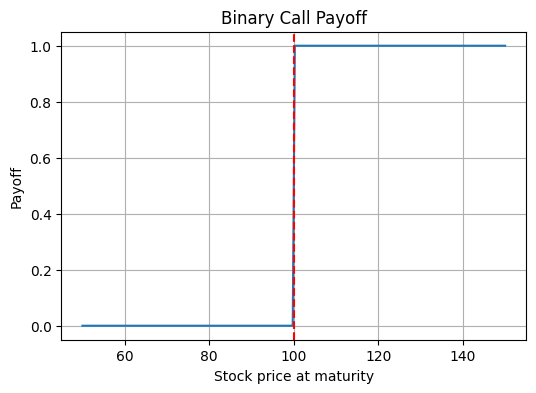

In [53]:
ST = np.linspace(50, 150, 200)
payoff = np.where(ST > K, 1, 0)
plt.plot(ST, payoff)
plt.axvline(K, color='red', linestyle='--')
plt.xlabel("Stock price at maturity")
plt.ylabel("Payoff")
plt.title("Binary Call Payoff")
plt.show()


**Q3.** Suppose the stock pays dividends at a rate of $\delta$. How would this affect the price calculations? Find the price of a call with $S_0=100.0, K=100.0, r=0.0, \sigma=0.1, T=1.0, \delta=0.1, n=252$.

**Explanation:**
<font color="#39e75f">  
The call option is cheaper when a stock pays dividends because the dividend payments reduce the expected future stock price. Since the company distributes some of their earnings to shareholders, their stock price won't grow as much. There's less potential gain for the call holder so the call is cheaper.

In terms of the risk-neutral probability of an up movement, the growth rate becomes r - $\delta$ instead of r, so the probability of an up movement decreases when dividends are involved.

In [57]:
#code for Q3

# Parameters
S0 = 100.0
K = 100.0
r = 0.0
sigma = 0.1
T = 1.0
delta = 0.1    # continuous dividend yield
n = 252

def binomial_dividend_call(S0, K, r, sigma, T, n, delta):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - delta) * dt) - d) / (u - d)  # incorporates the continuous dvidend rate


    # Stock price at maturity
    ST = S0 * d**np.arange(n, -1, -1) * u**np.arange(0, n + 1)  # finds every possible price from the combinations of ups and downs after n steps

    # Option values at maturity (call)
    C = np.maximum(ST - K, 0.0)

    # Backward induction
    discount = np.exp(-r * dt)
    for i in range(n, 0, -1):
        C = discount * (p * C[1:i+1] + (1 - p) * C[0:i]) # moves backwards through the tree, discounting the previous node until reaching t = 0

    # Call price at t=0
    call_price = C[0]
    return call_price

call_price = binomial_dividend_call(S0, K, r, sigma, T, n, delta)
call_price_no_div = binomial_price_call(S0, K, r, sigma, T, n)

print(f"Call Price with {delta} dividends: {call_price:.6f}")
print(f"Call Price without dividends: {call_price_no_div:.6f}")



Call Price with 0.1 dividends: 0.787333
Call Price without dividends: 3.983807


**Q4.** What is the difference between the real and risk-neutral probability of an up movement? Why might we care about the real probability?

**Explanation:**
<font color="#39e75f">  
The real probability is the true probability of a stock going up. In practice the real probability is impossible to find because there are many unknown variables that influence the real price of a stock. The risk-neutral probability is an estimate of the real probability that is used to price options in place of the real probability. The risk-neutral probability assumes investors don't care about risk and enforces the rule of no arbitrage.
<font color="#39e75f">  
The real probability is important because it reflects how stocks actually behave. It determines expected returns and risk.

